In [1]:
import matplotlib
matplotlib.use('nbagg')
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [2]:
%load_ext vplants.autowig.rich_display
%load_ext pyclanglite.rich_display

# Miscxx, PyEigen and StatisKit example

In [3]:
from vplants.autowig.asg import AbstractSemanticGraph
asg = AbstractSemanticGraph()

In [4]:
from vplants.autowig.front_end import front_end
from pyclanglite_plugin_manager.autowig import PyClangLiteFrontEndPlugin
front_end['pyclanglite'] = PyClangLiteFrontEndPlugin

## Miscxx

In [5]:
class MiscxxFrontEndPlugin(object):
    
    group = 'autowig'
    implements = 'front-end'
    
    def implementation(self, asg):
        ################### Preamble ###################
        headers = ['/usr/include/boost/shared_ptr.hpp']
        
        flags = ['-x', 'c++', '-g', '-std=c++11',
                 '-I/usr/include',
                 '-I/usr/local/lib/clang/3.7.0/include',
                 '-D__STDC_LIMIT_MACROS',
                 '-D__STDC_CONSTANT_MACROS']
        ################### Preamble ###################
        from vplants.autowig.front_end import front_end
        front_end = front_end['pyclanglite'].implementation
        return front_end(asg, headers, flags=flags, silent=True,
                  force_overload=True)
    
from vplants.autowig.front_end import front_end
front_end['miscxx'] = MiscxxFrontEndPlugin

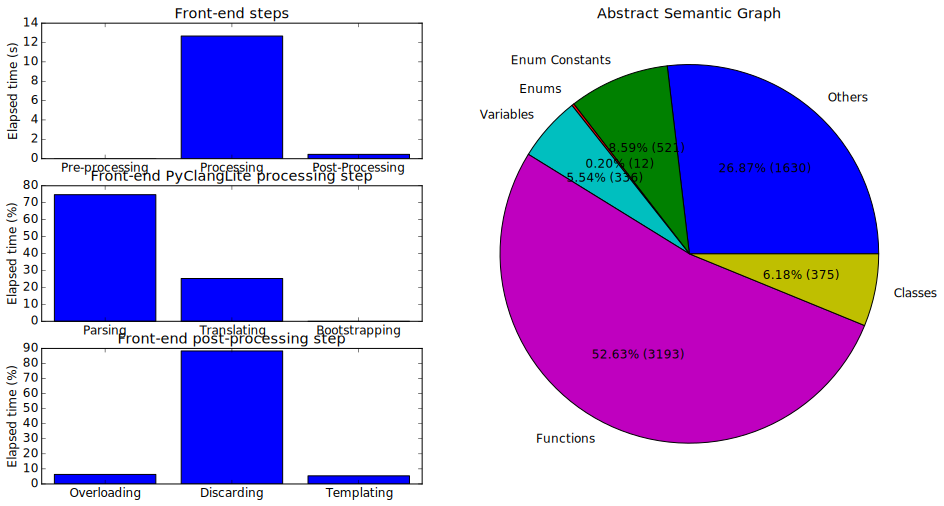

In [6]:
front_end.plugin_manager = 'miscxx'
front_end(asg)

In [7]:
class MiscxxMiddleEndPlugin(object):
    
    group = 'autowig'
    implements = 'middle-end'
    
    def implementation(self, asg):
        import time
        prev = time.time()
        ############### Pre-processing ###############
        asg['class ::boost::shared_ptr'].clean = False
        ############### Pre-processing ###############
        curr = time.time()
        from vplants.autowig.middle_end import middle_end
        middle_end = middle_end['default'].implementation
        diagnostic = middle_end(asg)
        diagnostic.preprocessing = curr - prev
        return diagnostic
    
from vplants.autowig.middle_end import middle_end
middle_end['miscxx'] = MiscxxMiddleEndPlugin

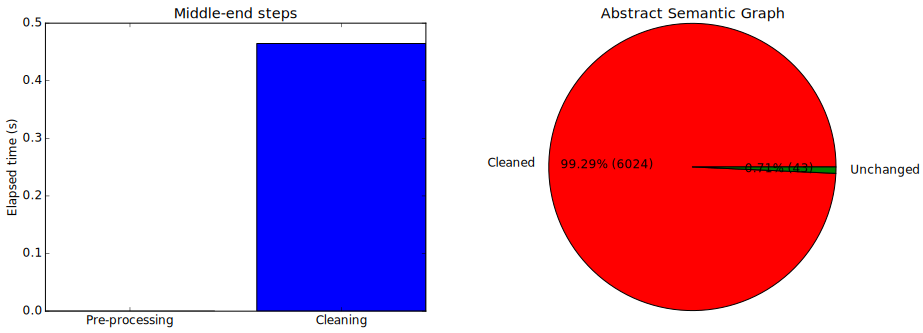

In [8]:
middle_end.plugin_manager = 'miscxx'
middle_end(asg)

ast[41861].get_return_type().get_type_ptr_or_null().is_lvalue_reference_type()

asg.functions('::Eigen::numext::real_ref(.*)').pop().result_type.is_reference

## PyEigen

In [9]:
class PyEigenFrontEndPlugin(object):
    
    group = 'autowig'
    implements = 'front-end'
    
    def implementation(self, asg):
        ################### Preamble ###################
        includedir = "../../pyeigen/build-scons/include"
        headers = [includedir + '/eigen/Dense']
        
        flags = ['-x', 'c++', '-g', '-std=c++11',
                 '-I/usr/include',
                 '-I' + includedir,
                 '-I/usr/local/lib/clang/3.7.0/include',
                 '-D__STDC_LIMIT_MACROS',
                 '-D__STDC_CONSTANT_MACROS']
        ################### Preamble ###################
        from vplants.autowig.front_end import front_end
        front_end = front_end['pyclanglite'].implementation
        return front_end(asg, headers, flags=flags, silent=True,
                  force_overload=True, bootstrap=10)
        
from vplants.autowig.front_end import front_end
front_end['pyeigen'] = PyEigenFrontEndPlugin

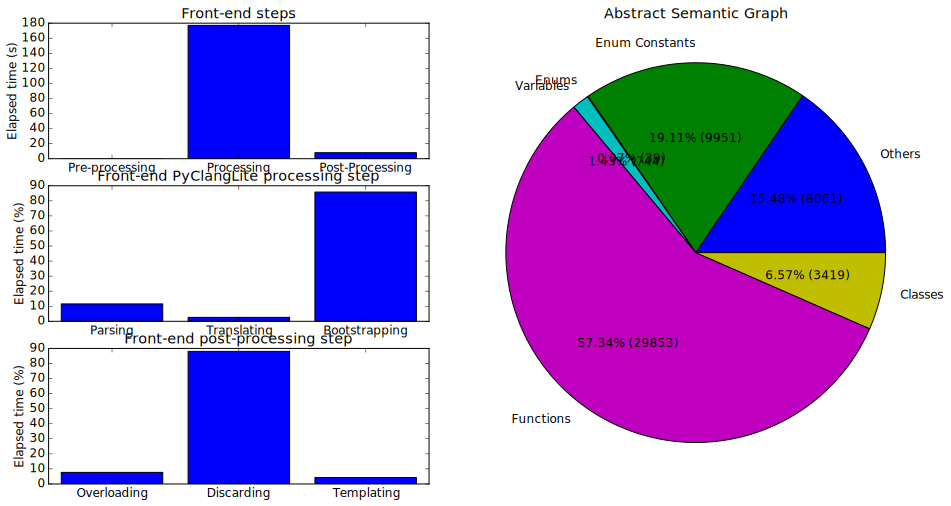

In [10]:
front_end.plugin_manager = 'pyeigen'
front_end(asg)

In [15]:
class PyEigenMiddleEndPlugin(object):
    
    group = 'autowig'
    implements = 'middle-end'
    
    def implementation(self, asg):
        import time
        prev = time.time()
        ##################### Post-processing #####################
        pattern = '^::Eigen::(Vector|Matrix)'
        for node in asg.typedefs(pattern):
            node.clean = False
        #pattern = pattern[:-4] + 'internal::(.*)'
        #for node in asg.nodes(pattern):
        #    node.clean = True
        ##################### Post-processing #####################
        curr = time.time()
        from vplants.autowig.middle_end import middle_end
        middle_end = middle_end['default'].implementation
        diagnostic = middle_end(asg)
        diagnostic.preprocessing = curr - prev
        return diagnostic
    
from vplants.autowig.middle_end import middle_end
middle_end['pyeigen'] = PyEigenMiddleEndPlugin

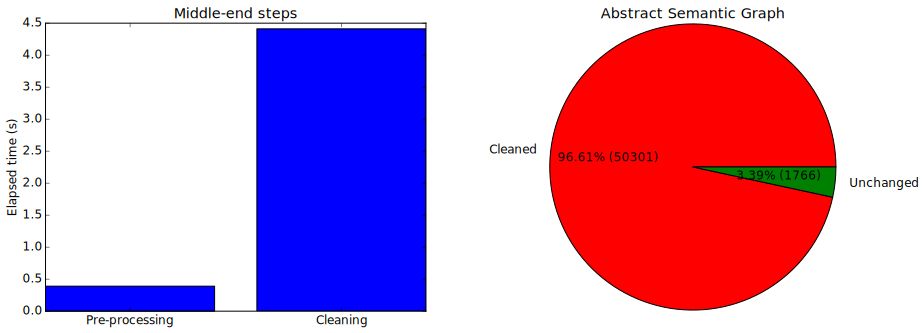

In [16]:
middle_end.plugin_manager = 'pyeigen'
middle_end(asg)

In [17]:
class PyEigenBackEndPlugin(object):
    
    group = 'autowig'
    implements = 'back-end'
    
    def implementation(self, asg):
        ################ Pre-processing #################
        ################ Pre-processing #################
        from vplants.autowig.back_end import back_end
        back_end = back_end['boost_python'].implementation
        pattern = '^(class |struct |union |enum |)'
        pattern += '::Eigen::(.*)'
        filename =  '../../pyeigen/src/generator/pyeigen.cpp'
        target = '../../pyeigen/src/pyeigen'
        return back_end(asg, filename,
                        target=target,
                        pattern=pattern,
                        on_disk=True)
    
from vplants.autowig.back_end import back_end
back_end['pyeigen'] = PyEigenBackEndPlugin

In [18]:
back_end.plugin_manager = 'pyeigen'
back_end(asg)

Total files generated,1587 (f)
Total source lines of code,22964 (l)
Elapsed time,5.15 (s)
Development effort estimate,100.34 (p.m)
Schedule estimate,12.54 (m)
Estimated average number of developers,8.0 (p)


In [19]:
from vplants.autowig.scons import *
asg.add_sconstruct('../../pyeigen')
asg.scons('-j','2')

## StatisKit

## Miscxx